In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 121M/121M [00:03<00:00, 35.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [4]:
# prompt: link drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


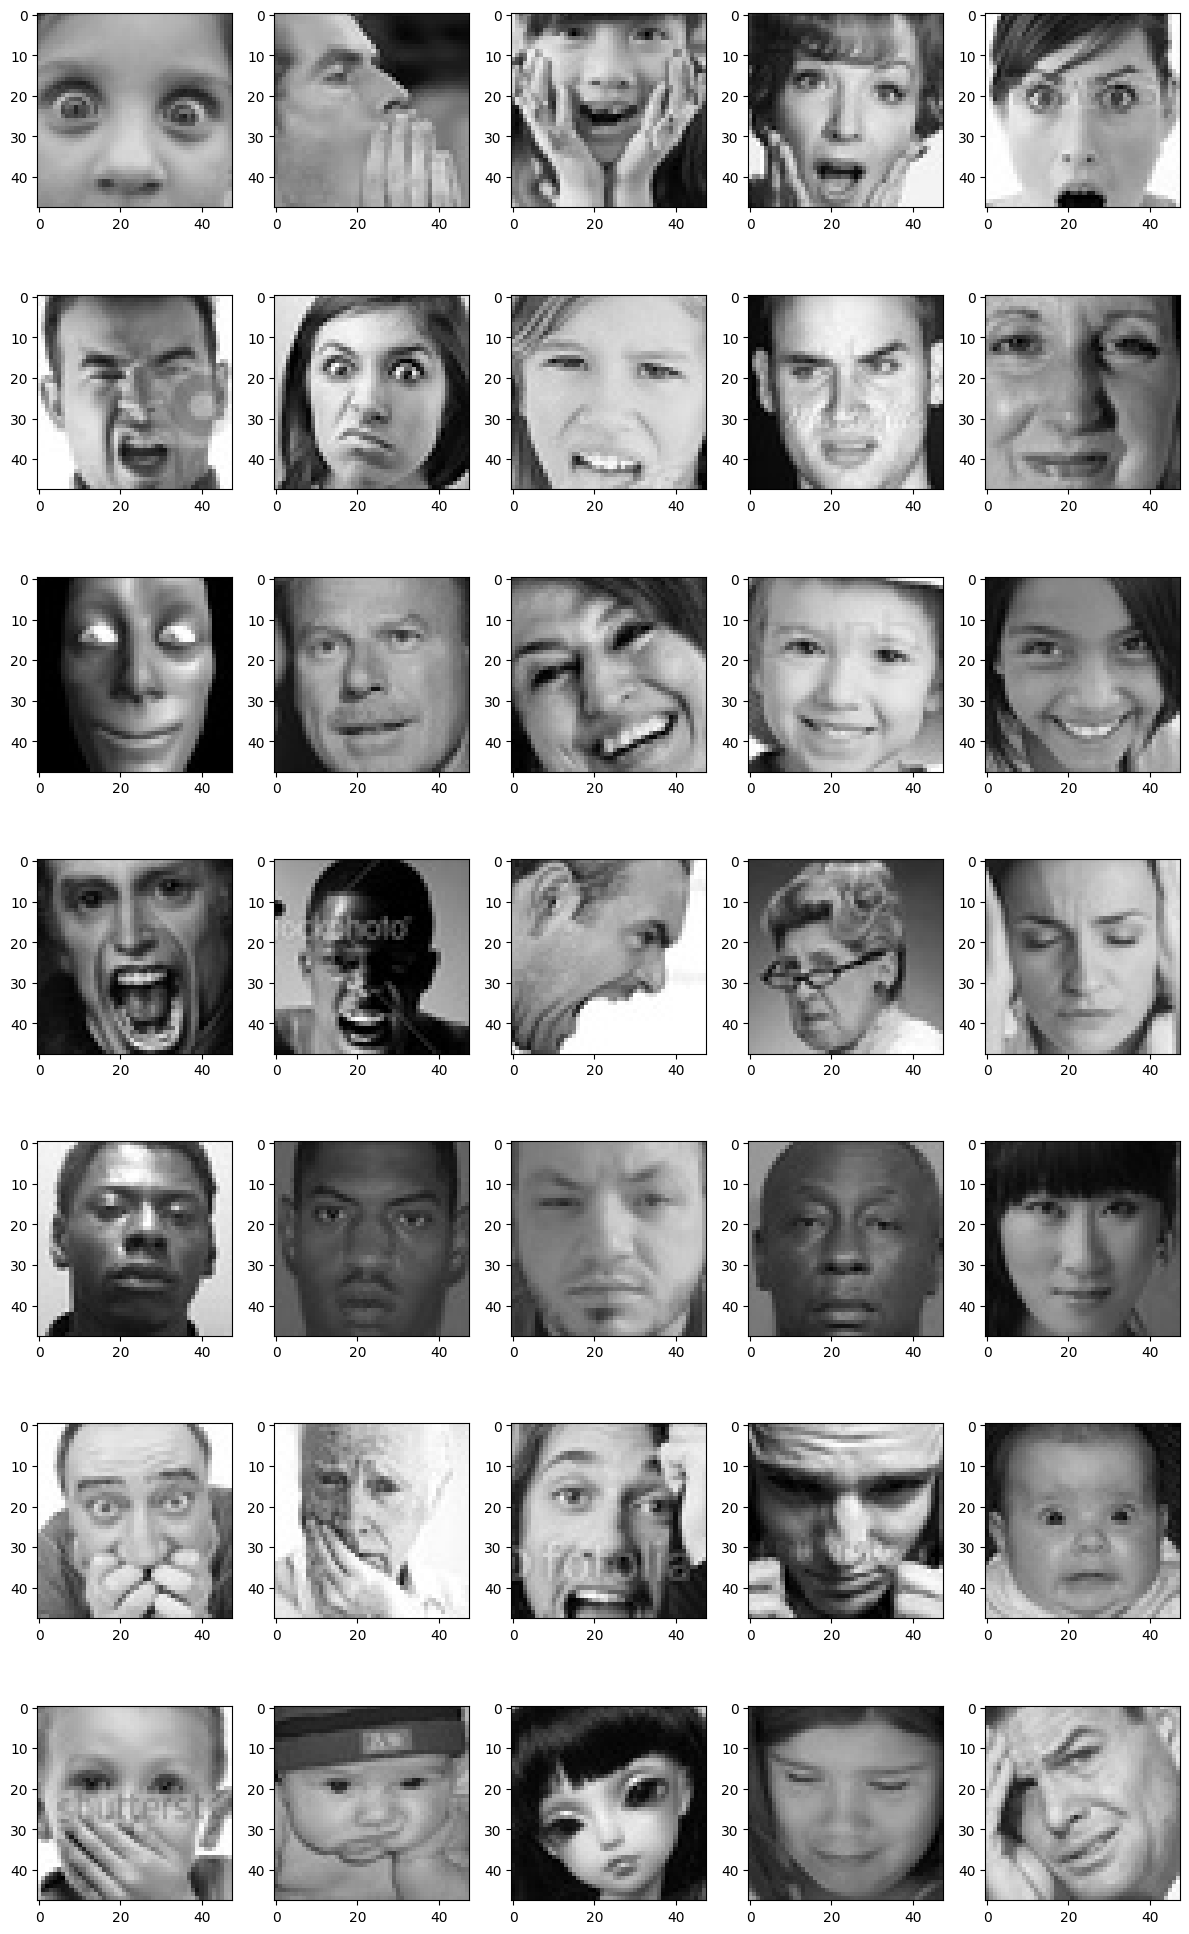

In [5]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = f"{path}/images/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [6]:
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3205 surprise images
436 disgust images
7164 happy images
3993 angry images
4982 neutral images
4103 fear images
4938 sad images


In [7]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
print(nb_classes)

7


In [10]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Use model.fit instead of model.fit_generator
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.3961 - loss: 1.5585 - val_accuracy: 0.4081 - val_loss: 1.5930
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3594 - loss: 1.6395 - val_accuracy: 0.4101 - val_loss: 1.5819
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.4242 - loss: 1.4982 - val_accuracy: 0.4540 - val_loss: 1.4317
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4219 - loss: 1.4509 - val_accuracy: 0.4550 - val_loss: 1.4296
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.4353 - loss: 1.4671 - val_accuracy: 0.4611 - val_loss: 1.4160
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3984 - loss: 1.4702 - val_accuracy: 0.4639 - val_loss: 1.4056
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.4542 - loss: 1.4083 - val_accuracy: 0.4845 - val_loss: 1.3444
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4766 - loss: 1.4059 - val_ac

In [11]:
model_path='/content/drive/MyDrive/DNN'
model_json = model.to_json()

with open(f"{model_path}/model.json", "w") as json_file:
    json_file.write(model_json)

In [15]:
from keras.models import load_model

# Define model path
model_path = "/content/drive/MyDrive/DNN"

# Save the entire model in HDF5 format
model.save(f"{model_path}/model.h5") # Added .h5 extension

# Save in TensorFlow's SavedModel format
# Use model.export for SavedModel format
model.export(f"{model_path}/saved_model") # Changed from model.save to model.export

# Save only the model weights
# model.save_weights(f"{model_path}/model_weights.h5") # Added .h5 extension
# Save only the model weights
model.save_weights(f"{model_path}/model_weights.weights.h5") # Changed filename to include '.weights'
print("Model saved in HDF5, TensorFlow SavedModel, and weights formats successfully!")

Saved artifact at '/content/drive/MyDrive/DNN/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138889137786896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889138989648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889115628560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889115629520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889137794960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889137788240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889115630672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889115631056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889116156752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138889116157328: TensorSpec(shape=(), dtype=tf.resource, name=No

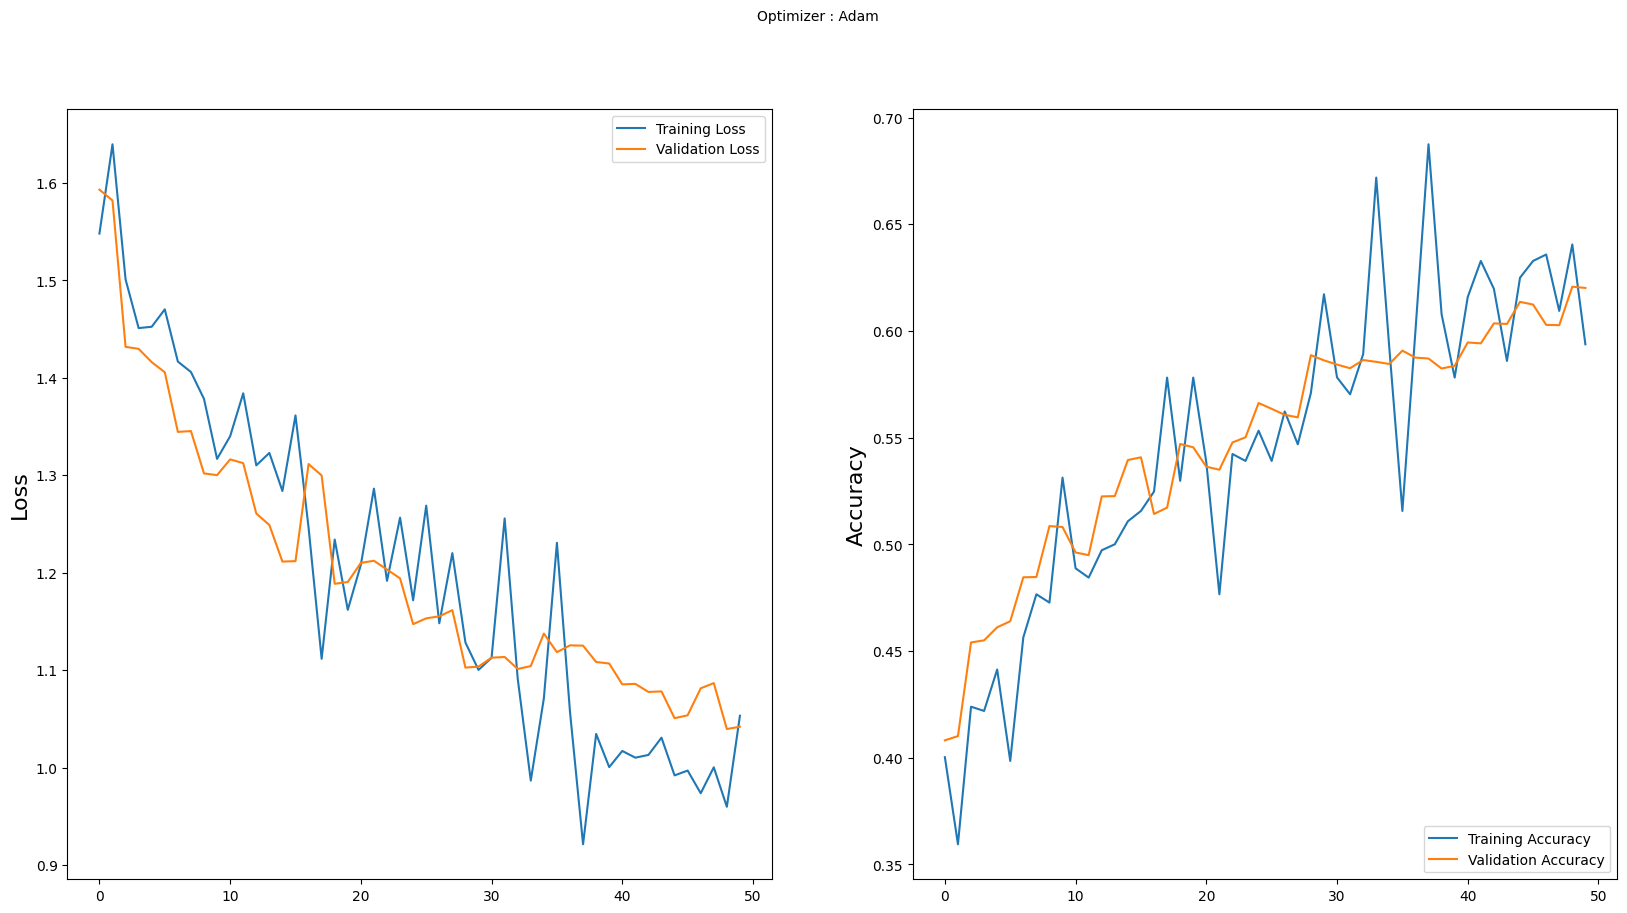

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
# Change 'acc' to 'accuracy' to match the metric used in model.compile
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


<Figure size 640x480 with 0 Axes>

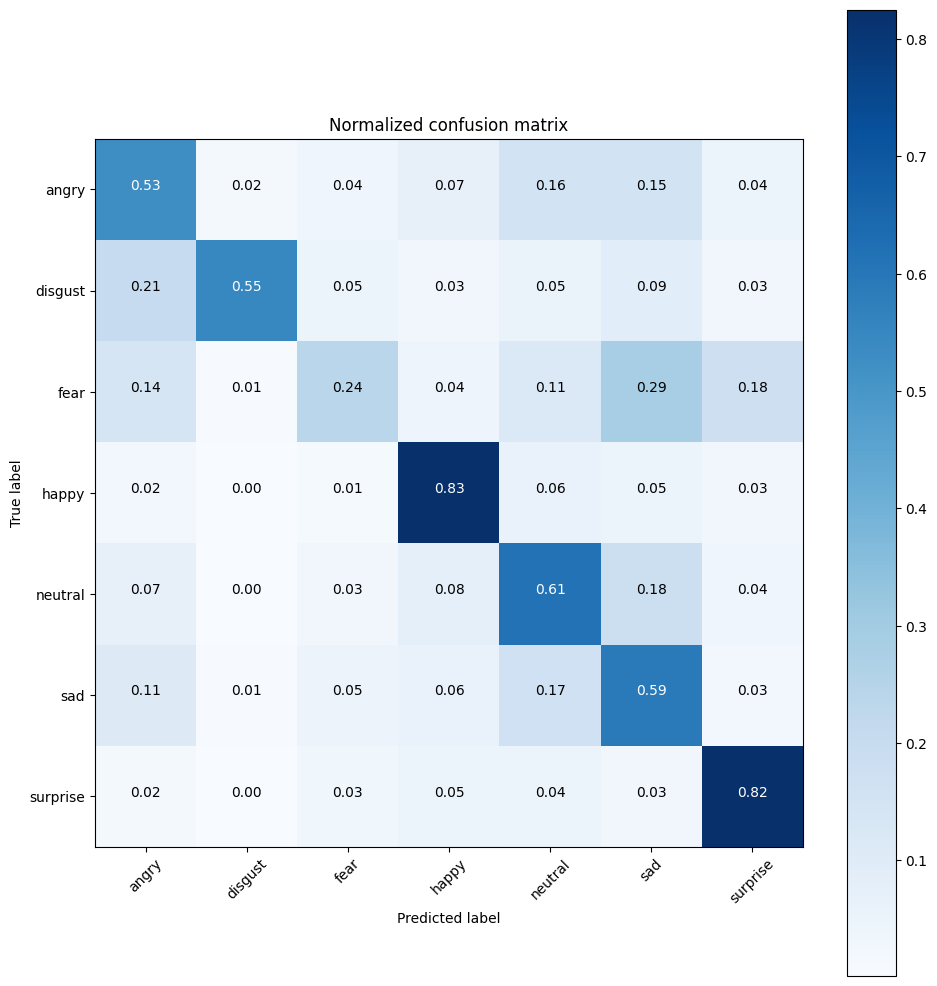

In [19]:
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()